In [1]:
import openai
import pandas as pd
import numpy as np
import math
import tqdm

from sklearn.metrics import f1_score, accuracy_score, precision_score


In [2]:
!pip3 install openai

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Are simple/informal comments more toxic?

In this notebook we'll use Marianna Apidianaki's method of calculating interpretable dimensions in semantic vector space on the fly using seed pairs. To start, we want to look at the same dimensions: formality and complexity. But we want to look at the sentence level rather than the word level. 

## Step 1: Generating Emotionality seed pairs

We want sevenish pairs of sentences, or really two symmetrical groups of sentences, that can be used to calculate a dimension. 

In [3]:
sentences = """Last week I got into a car accident.
She had some amazing news to share but nobody to share it with.
Sometime you just have to give up and win by cheating.
They desperately needed another drummer since the current one only knew how to play bongos.
The bread dough reminded her of Santa Clause’s belly.
He realized there had been several deaths on this road, but his concern rose when he saw the exact number.
Trash covered the landscape like sprinkles do a birthday cake."""
sentences = sentences.split("\n")
sentences

['Last week I got into a car accident.',
 'She had some amazing news to share but nobody to share it with.',
 'Sometime you just have to give up and win by cheating.',
 'They desperately needed another drummer since the current one only knew how to play bongos.',
 'The bread dough reminded her of Santa Clause’s belly.',
 'He realized there had been several deaths on this road, but his concern rose when he saw the exact number.',
 'Trash covered the landscape like sprinkles do a birthday cake.']

### Step 1: Load and use GPT to generate sentences

In [4]:
from openai import OpenAI
client = OpenAI() # OPENAI_API_KEY environment variable must be set. see quickstart tutorial here: https://platform.openai.com/docs/quickstart?context=python



Try an example completion

In [5]:
sentence = sentences[0]

messages=[
    {"role": "system", "content": "You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property."},
    {"role": "user", "content": "Rephrase the following statement to use language that is more complex: \"{}\" .".format(sentence)}
  ]


In [6]:
completion = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=messages
)

print(completion.choices[0].message)

ChatCompletionMessage(content='During the previous week, I happened to find myself involved in a vehicular collision.', role='assistant', function_call=None, tool_calls=None)


In [7]:
completion.choices[0]

Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='During the previous week, I happened to find myself involved in a vehicular collision.', role='assistant', function_call=None, tool_calls=None))

We'll feed this output back to the api 

In [8]:
messages.append({'role': 'system', 'content': completion.choices[0].message.content})
messages.append({"role": "user", "content": "Good. Rephrase the sentence again to use language that is even more complex."})
messages

[{'role': 'system',
  'content': 'You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property.'},
 {'role': 'user',
  'content': 'Rephrase the following statement to use language that is more complex: "Last week I got into a car accident." .'},
 {'role': 'system',
  'content': 'During the previous week, I happened to find myself involved in a vehicular collision.'},
 {'role': 'user',
  'content': 'Good. Rephrase the sentence again to use language that is even more complex.'}]

In [9]:
def complete(messages):
    completion = client.chat.completions.create(
      model="gpt-3.5-turbo",
      messages=messages,
      seed=42
    )
    return completion.choices[0].message.content

complete(messages)

'In the most recent seven-day span, my experience was such that I became entangled in a distressing collision involving motor vehicles.'

### prompt templates

In [10]:
# dictionary of the adjectives we use (property adjective and antonym) to create prompts

property_dict = {
    'complexity':   ('complex', 'simple'),
    'emotion':      ('emotional', 'emotionless'),
    'formality':       ('formal', 'casual')
}


We will generate sentences from a series of templates. For each sentence, we want to generate 'more x', 'even more x', as well as 'less x' and 'even less x'. Because the model often produces longer sentences for 'more' prompts, we also prompt for rephrasings using an antonymous adjective. So, for example, we ask for rephrasings that are "more complex" as well as rephrasings that are "less simple". We then use all of these rephrasings to calculate the complexity dimension.

In [11]:
# TODO save 5 responses instead of 1


adj, antonym = property_dict['formality']

data = []

for sent in sentences:

    for i, x in enumerate([adj, antonym]):
        print(i)
        print(x)
        messages=[
            {"role": "system", "content": "You are a rewording assistant, skilled in transforming a statement to express more or less of a given quality or property. The new statement should be the same length."},
        ]

        
        # more
        more_messages = messages + [{"role": "user", "content": "Rephrase the following statement to use language that is more {}. The new statement should be the same length: \"{}\" .".format(x,sent)}]
        more = complete(more_messages)
        print(more)
        
        # less
        less_messages = messages + [{"role": "user", "content": "Rephrase the following statement to use language that is less {}. The new statement should be the same length: \"{}\" .".format(x,sent)}]
        less = complete(less_messages)
        print(less)
        
        row = {
             'sentence': sent,
             'text1': more,
             'text2': less,
             'low': less if i==0 else more,
             'high': more if i==0 else less,
             'more': 1,
             'even_more': 0,
             'less': 1,
             'even_less':  0,
             'property': 'complexity',
             'adjective': x,
             'antonym?': 0 if i == 0 else 1 # the second in the pair is the antonym
        }
        data.append(row)
                
        # even more
        even_more_messages = more_messages + [{"role": "system", "content": more}] + [{"role": "user", "content": "Good. Rephrase the sentence again to use language that is even more {}. The new statement should be the same length.".format(x)}]
        even_more = complete(even_more_messages)
        print(even_more)
        
        # even less
        even_less_messages = less_messages + [{"role": "system", "content": less}] + [{"role": "user", "content": "Good. Rephrase the sentence again to use language that is even less {}. The new statement should be the same length.".format(x)}]
        even_less = complete(even_less_messages)
        print(even_less)
        
        row = {
             'sentence': sent,
             'text1': even_more,
             'text2': even_less,
             'low': even_less if i==0 else even_more, #switches on the antonym
             'high': even_more if i==0 else even_less,
             'more': 0,
             'even_more': 1,
             'less': 0,
             'even_less':  1,
             'property': 'complexity',
             'adjective': x,
             'antonym?': 0 if i == 0 else 1 # the second in the pair is the antonym
        }
        data.append(row)

        # TODO even even more


    
df = pd.DataFrame.from_records(data)
df

0
formal
Last week, I experienced a vehicular collision.
I had a car crash last week.
Last week, I was involved in a motor vehicle collision.
I had a car wreck last week.
1
casual
I had a car crash last week.
I was involved in an automobile collision last week.
I had a car wreck last week.
I experienced a vehicular collision last week.
0
formal
She possessed momentous tidings to disclose, yet no one with whom to disclose them.
She had some awesome news to tell, but no one to tell it to.
She held within her possession extraordinary information to impart, however, she found herself devoid of any suitable individuals with whom she could disseminate the aforementioned information.
She had some awesome news, but nobody to share it with.
1
casual
She had some awesome news to tell, but no one to share it with.
She possessed extraordinary news to disclose, yet lacked anyone to share it with.
She had some awesome news to spill, but nobody to share it with.
She had remarkable news to convey, but

,sentence,text1,text2,low,high,more,even_more,less,even_less,property,adjective,antonym?
0,Last week I got into a car accident.,"Last week, I experienced a vehicular collision.",I had a car crash last week.,I had a car crash last week.,"Last week, I experienced a vehicular collision.",1,0,1,0,complexity,formal,0
1,Last week I got into a car accident.,"Last week, I was involved in a motor vehicle c...",I had a car wreck last week.,I had a car wreck last week.,"Last week, I was involved in a motor vehicle c...",0,1,0,1,complexity,formal,0
2,Last week I got into a car accident.,I had a car crash last week.,I was involved in an automobile collision last...,I had a car crash last week.,I was involved in an automobile collision last...,1,0,1,0,complexity,casual,1
3,Last week I got into a car accident.,I had a car wreck last week.,I experienced a vehicular collision last week.,I had a car wreck last week.,I experienced a vehicular collision last week.,0,1,0,1,complexity,casual,1
4,She had some amazing news to share but nobody ...,"She possessed momentous tidings to disclose, y...","She had some awesome news to tell, but no one ...","She had some awesome news to tell, but no one ...","She possessed momentous tidings to disclose, y...",1,0,1,0,complexity,formal,0
5,She had some amazing news to share but nobody ...,She held within her possession extraordinary i...,"She had some awesome news, but nobody to share...","She had some awesome news, but nobody to share...",She held within her possession extraordinary i...,0,1,0,1,complexity,formal,0
6,She had some amazing news to share but nobody ...,"She had some awesome news to tell, but no one ...","She possessed extraordinary news to disclose, ...","She had some awesome news to tell, but no one ...","She possessed extraordinary news to disclose, ...",1,0,1,0,complexity,casual,1
7,She had some amazing news to share but nobody ...,"She had some awesome news to spill, but nobody...","She had remarkable news to convey, but was wit...","She had some awesome news to spill, but nobody...","She had remarkable news to convey, but was wit...",0,1,0,1,complexity,casual,1
8,Sometime you just have to give up and win by c...,"At times, one must simply surrender and achiev...",Sometimes you gotta let go and cheat to come o...,Sometimes you gotta let go and cheat to come o...,"At times, one must simply surrender and achiev...",1,0,1,0,complexity,formal,0
9,Sometime you just have to give up and win by c...,"On certain occasions, it is necessary to relin...","Sometimes ya just gotta cheat to win, y'know?","Sometimes ya just gotta cheat to win, y'know?","On certain occasions, it is necessary to relin...",0,1,0,1,complexity,formal,0


Save so we don't have to query the api every time

In [12]:
df.to_csv('make_it_more_formal_pilot_seed_sentences.csv')

## Step 2: Calculating the emotional dimension



In [13]:
df = pd.read_csv('make_it_more_formal_pilot_seed_sentences.csv')

Now that we have our seed sentences for the complexity dimension, we need to get the vector differences for the seed pairs.

We generated 8 sentences for each original seed sentence, meaning we have four seed pairs.

The formulas for the four seed pairs are as follows:

- ( adjective + more ) - (adjective + less)
- ( adjective + even more ) - (adjective + even less)
- ( antonym + less ) - (antonym + more )
- ( antonym + even less ) - (antonym + even more )

First we get an embedding for both complementary sentences in each row (text1 and text2). Then, for each seed sentence we calculate these four formulae to get the vector differences. And then we average those together. 

In [14]:
df.head(5)

,Unnamed: 0,sentence,text1,text2,low,high,more,even_more,less,even_less,property,adjective,antonym?
0,0,Last week I got into a car accident.,"Last week, I experienced a vehicular collision.",I had a car crash last week.,I had a car crash last week.,"Last week, I experienced a vehicular collision.",1,0,1,0,complexity,formal,0
1,1,Last week I got into a car accident.,"Last week, I was involved in a motor vehicle c...",I had a car wreck last week.,I had a car wreck last week.,"Last week, I was involved in a motor vehicle c...",0,1,0,1,complexity,formal,0
2,2,Last week I got into a car accident.,I had a car crash last week.,I was involved in an automobile collision last...,I had a car crash last week.,I was involved in an automobile collision last...,1,0,1,0,complexity,casual,1
3,3,Last week I got into a car accident.,I had a car wreck last week.,I experienced a vehicular collision last week.,I had a car wreck last week.,I experienced a vehicular collision last week.,0,1,0,1,complexity,casual,1
4,4,She had some amazing news to share but nobody ...,"She possessed momentous tidings to disclose, y...","She had some awesome news to tell, but no one ...","She had some awesome news to tell, but no one ...","She possessed momentous tidings to disclose, y...",1,0,1,0,complexity,formal,0


Obviously we run into the problem where typically vectors are word or token-level and we want sentence-level representations. The absolute simplest thing I can think of to do here is to use SentenceBERT, which we will download from huggingface.

After initializing the model, we generate vector representations for each sentence in the informal list and for each corresponding sentence in the formal list. We subtract the vectors from one another and then take the average, leaving us with a vector that represents the formality dimension. We can rate any sentence vector(s) on the formality dimension by giving them (as a list) to the function predict_scalarproj along with the dimension itself. 

In [15]:
# load sbert
!pip install -U sentence-transformers

DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [51]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')

low = df['low'].to_list()
high = df['high'].to_list()

#Sentences are encoded by calling model.encode()
embeddings1 = model.encode(low)
embeddings2 = model.encode(high)


#df = df.assign(embedding1=embeddings1.tolist())
#df = df.assign(embedding2=embeddings2.tolist())


df.head(28)

# #Print the embeddings
# for sentence, embedding in zip(positive[:5], pos_embeddings[:5]):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding[:100])
#     print("")

,Unnamed: 0,sentence,text1,text2,low,high,more,even_more,less,even_less,property,adjective,antonym?
0,0,Last week I got into a car accident.,"Last week, I experienced a vehicular collision.",I had a car crash last week.,I had a car crash last week.,"Last week, I experienced a vehicular collision.",1,0,1,0,complexity,formal,0
1,1,Last week I got into a car accident.,"Last week, I was involved in a motor vehicle c...",I had a car wreck last week.,I had a car wreck last week.,"Last week, I was involved in a motor vehicle c...",0,1,0,1,complexity,formal,0
2,2,Last week I got into a car accident.,I had a car crash last week.,I was involved in an automobile collision last...,I had a car crash last week.,I was involved in an automobile collision last...,1,0,1,0,complexity,casual,1
3,3,Last week I got into a car accident.,I had a car wreck last week.,I experienced a vehicular collision last week.,I had a car wreck last week.,I experienced a vehicular collision last week.,0,1,0,1,complexity,casual,1
4,4,She had some amazing news to share but nobody ...,"She possessed momentous tidings to disclose, y...","She had some awesome news to tell, but no one ...","She had some awesome news to tell, but no one ...","She possessed momentous tidings to disclose, y...",1,0,1,0,complexity,formal,0
5,5,She had some amazing news to share but nobody ...,She held within her possession extraordinary i...,"She had some awesome news, but nobody to share...","She had some awesome news, but nobody to share...",She held within her possession extraordinary i...,0,1,0,1,complexity,formal,0
6,6,She had some amazing news to share but nobody ...,"She had some awesome news to tell, but no one ...","She possessed extraordinary news to disclose, ...","She had some awesome news to tell, but no one ...","She possessed extraordinary news to disclose, ...",1,0,1,0,complexity,casual,1
7,7,She had some amazing news to share but nobody ...,"She had some awesome news to spill, but nobody...","She had remarkable news to convey, but was wit...","She had some awesome news to spill, but nobody...","She had remarkable news to convey, but was wit...",0,1,0,1,complexity,casual,1
8,8,Sometime you just have to give up and win by c...,"At times, one must simply surrender and achiev...",Sometimes you gotta let go and cheat to come o...,Sometimes you gotta let go and cheat to come o...,"At times, one must simply surrender and achiev...",1,0,1,0,complexity,formal,0
9,9,Sometime you just have to give up and win by c...,"On certain occasions, it is necessary to relin...","Sometimes ya just gotta cheat to win, y'know?","Sometimes ya just gotta cheat to win, y'know?","On certain occasions, it is necessary to relin...",0,1,0,1,complexity,formal,0


In [17]:
difference_vecs = (embeddings2 - embeddings1)

In [18]:
dimvec = np.mean(difference_vecs, axis = 0)
dimvec

array([ 1.92667600e-02,  3.14936340e-02, -2.01713573e-02,  2.11338699e-03,
       -2.12942269e-02,  2.81975372e-03,  2.20464896e-02, -8.79007485e-03,
        4.23724501e-04, -3.19308368e-03,  1.75802354e-02, -1.11452090e-02,
        7.80578051e-03, -7.51449773e-03,  2.56887241e-03, -7.21021323e-03,
        2.74657421e-02,  5.22517739e-03,  1.04498109e-02,  3.69844846e-02,
        2.77173519e-02, -6.01621752e-04, -5.40669309e-03,  4.32262244e-03,
       -7.18874484e-03, -5.48481708e-03,  1.65983606e-02, -4.00956394e-03,
        3.09256576e-02, -1.33299828e-02,  6.58466434e-03, -6.72756135e-03,
       -7.39270530e-04,  2.70621814e-02,  4.35449136e-03,  1.97437163e-02,
        1.85412227e-03,  1.52806973e-03, -7.27212173e-04, -1.21360468e-02,
       -1.43129379e-02, -1.59615930e-02, -1.54907908e-02,  4.34343657e-03,
       -1.98971629e-02,  1.42982497e-03, -1.44781321e-02,  3.44041027e-02,
       -4.55364287e-02, -1.83562152e-02, -2.74522994e-02, -1.20050292e-02,
       -2.63133608e-02,  

In [19]:
#### from marianna + katrin
# seed-based method
# averaging over seed pair vectors
# def dimension_seedbased(seeds_pos, seeds_neg, space, paired = False):
#     diffvectors = [ ]
    
#     for negword, posword in _make_seedpairs(seeds_pos, seeds_neg, paired = paired):
#         diffvectors.append(space[posword] - space[negword])

#     # average
#     dimvec = np.mean(diffvectors, axis = 0)
#     return dimvec


In [20]:
def dimension_seedbased():
    return dimvec

In [21]:
complexity_dimension = dimension_seedbased()

In [22]:
# vector scalar projection (from marianna + katrin)
def predict_scalarproj(veclist, dimension):
    dir_veclen = math.sqrt(np.dot(dimension, dimension))
    return [np.dot(v, dimension) / dir_veclen for v in veclist]

# Step 2.5 Debugging the Formality Dimension

Initial validation on Simple PPDB (Step 3 below) was not very good (read: very bad). We got 43% accuracy predicting which of two words/phrases was simpler, meaning: if we'd done nothing at all, the world would be a better place. 

So, there are four possibilities in order of increasing severity.

1) we ran the validation experiment wrong
2) we calculated the complexity dimension wrong
3) we did everything right (i.e. no bugs) but are seeing this result because the validation dataset is out of domain (model and complexity dimension are for sentences; the dataset is just words and phrases).
4) we did everything right (i.e. no bugs) and the dimension is just not helpful at all in predicting complexity

We can rule out 2 by checking that the seed pairs we used to calculate the dimension in fact line up the way they should.

In [52]:
golds = []
for i, row in df.iterrows():
    
    gold = row["text1"] if (row["adjective"] == "casual") else row["text2"]
    golds.append(gold)
    
    print(row["text1"])
    print(row["text2"])
    print(gold)
    print()
    


Last week, I experienced a vehicular collision.
I had a car crash last week.
I had a car crash last week.

Last week, I was involved in a motor vehicle collision.
I had a car wreck last week.
I had a car wreck last week.

I had a car crash last week.
I was involved in an automobile collision last week.
I had a car crash last week.

I had a car wreck last week.
I experienced a vehicular collision last week.
I had a car wreck last week.

She possessed momentous tidings to disclose, yet no one with whom to disclose them.
She had some awesome news to tell, but no one to tell it to.
She had some awesome news to tell, but no one to tell it to.

She held within her possession extraordinary information to impart, however, she found herself devoid of any suitable individuals with whom she could disseminate the aforementioned information.
She had some awesome news, but nobody to share it with.
She had some awesome news, but nobody to share it with.

She had some awesome news to tell, but no one 

In [53]:
predictions = []

for i, row in df.iterrows():
    left = model.encode(row["text1"])
    right = model.encode(row["text2"])
    preds = predict_scalarproj([left,right], dimvec)
    simple_pred = np.argmin(preds)

    # text1 is simpler if we used the "more complex" prompt
    
    if simple_pred == 0: # we predict the 'more simple text' as simpler
        simplest_word = row["text1"]
    else:
        simplest_word = row["text2"]

    # print(golds[i])
    # print(simplest_word)
    # print()
    predictions.append(simplest_word)

In [54]:
# accuracy
acc = accuracy_score(golds, predictions)
print(acc)



# this is binary but rather than compute the binary just pretend we have a million labels and take the macro average
f1 = f1_score(golds, predictions, average="macro")
print(f1)

1.0
1.0


The dimension appears to be being calculated correctly

# Step 3: validating the formality dimension

does it behave the same way as a standard classifier?


We load a regular classifier

We run this prediction method and the formality classifier on the formality dataset. 

We compare. Is the dimension-based method that much worse?

We load a complexity dataset - perhaps the word-based one that Marianna uses.

We order the entries by their complexity rating and look at where they fall on our complexity axis.

We are going to use Simple PPDB

In [26]:
!pip3 install openpyxl

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [27]:
simple_ppdb = pd.read_csv('~/Downloads/SimplePPDB/human-labeled-data/training-pairs', delimiter="\t")
simple_ppdb

,majority,total,x,y,gold
0,6,7,the wrath,rage,"turkers=""rage"""
1,6,7,toys,playthings,"turkers=""toys"""
2,5,7,proposed,are offering,"turkers=""are offering"""
3,7,7,farther,even further,"turkers=""farther"""
4,4,7,our youth,adolescents,"turkers=""our youth"""
...,...,...,...,...,...
3752,5,7,the stress,tensions,"turkers=""the stress"""
3753,4,7,households,canadian households,"turkers=""households"""
3754,4,7,saintly,sacred,"turkers=""NA"""
3755,6,7,fuss,bullshit,"turkers=""fuss"""


limit to rows with majority 5 or more out of seven, and clean up the row with the simplification

In [28]:
def text_between_quotes(text):
    return text.split('"')[1::2][0]
    
simple_ppdb = simple_ppdb[simple_ppdb['majority']/simple_ppdb['total'] >= 5/7 ]

len(simple_ppdb)

1915

In [29]:
golds = []
for i,row in simple_ppdb.iterrows():

    gold = text_between_quotes(row.gold)
    #print(gold)
    golds.append(gold)

print(len(golds))

simple_ppdb['gold'] = golds

simple_ppdb

1915


/var/folders/9m/vzvx58rs51v_x5nm620fz4xr0000gn/T/ipykernel_68920/3137916988.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simple_ppdb['gold'] = golds


,majority,total,x,y,gold
0,6,7,the wrath,rage,rage
1,6,7,toys,playthings,toys
2,5,7,proposed,are offering,are offering
3,7,7,farther,even further,farther
5,5,7,upper,high-end,upper
...,...,...,...,...,...
3747,6,7,farmland,agro-industrial,farmland
3749,6,7,finishing,are done,are done
3750,6,7,cartons,canisters,cartons
3752,5,7,the stress,tensions,the stress


you want to add one column to this data: "predicted". you want to add a coolumn with the word predicted to be simpler.

So you need a function that predicts complexity values for both word and returns the word with the lower predicted value on the complexity dimension.

In [30]:
predictions = []

for i, row in simple_ppdb.iterrows():
    left = model.encode(row["x"])
    right = model.encode(row["y"])
    preds = predict_scalarproj([left,right], dimvec)
    simple_pred = np.argmin(preds)
    if simple_pred == 0:
        simplest_word = row["x"]
    else:
        simplest_word = row["y"]

    # print(row["gold"])
    # print(simplest_word)
    predictions.append(simplest_word)

In [60]:
simple_ppdb['prediction'] = predictions

simple_ppdb['correct'] = np.where(simple_ppdb['prediction']== simple_ppdb['gold'], True, False)

#simple_ppdb['correct?'] = simple_ppdb[simple_ppdb['prediction'] == simple_ppdb['gold']]

simple_ppdb.head(5)

ValueError: Length of values (28) does not match length of index (1915)

Now that we have predicted the simplest word using our calculated complexity dimension, we measure how well the complexity dimension aligns with human judgments (keeping in mind that we have just sbertized single words and phrases so that could potentially be a little funky.

In [59]:
#accuracy
print(simple_ppdb['correct'].value_counts())

print(1263 / (1263 + 636))

# accuracy
acc = accuracy_score(simple_ppdb["gold"], predictions)
print(acc)

# precision
prec = precision_score(simple_ppdb["gold"], predictions, average="macro")
print(prec)

# this is binary but rather than compute the binary just pretend we have a million labels and take the macro average
f1 = f1_score( simple_ppdb["gold"], predictions, average="macro")
print(f1)

correct
True     1263
False     652
Name: count, dtype: int64
0.665086887835703


ValueError: Found input variables with inconsistent numbers of samples: [1915, 28]

In [33]:
# precision

## Step 4: Rating Toxicity Datasets for complexity

We'll start with the 1000-length parallel dataset from the text detoxification paper. 

We load it in

We SBERTize the sentences

We pass them to the prediction method. 

We observe: do toxic and nontoxic comments differ wrt formality?

In [34]:
!pip install datasets

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


DEPRECATION: Loading egg at /usr/local/lib/python3.11/site-packages/avgn-0.1.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation.. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [35]:
from datasets import load_dataset

dataset = load_dataset("civil_comments")

Found cached dataset parquet (/Users/gabriellachronis/.cache/huggingface/datasets/parquet/civil_comments-e92c9358c47debf9/0.0.0/14a00e99c0d15a23649d0db8944380ac81082d4b021f398733dd84f3a6c569a7)


  0%|          | 0/3 [00:00<?, ?it/s]

In [36]:
dataset["train"][0]

{'text': "This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 'toxicity': 0.0,
 'severe_toxicity': 0.0,
 'obscene': 0.0,
 'threat': 0.0,
 'insult': 0.0,
 'identity_attack': 0.0,
 'sexual_explicit': 0.0}

In [37]:
dataset["train"][:10]['text']

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
 "Is this something I'll be able to install on my site? When will you be releasing it?",
 'haha you guys are a bunch of losers.',
 'ur a sh*tty comment.',
 'hahahahahahahahhha suck it.',
 'FFFFUUUUUUUUUUUUUUU',
 'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
 "It was a great show. Not a combo I'd of expected to be good together but it was."]

In [38]:
###################################
#########
# predicting ratings on a dimension

# ...
# when we only have the dimension:
# vector scalar projection
def predict_scalarproj(veclist, dimension):
    dir_veclen = math.sqrt(np.dot(dimension, dimension))
    return [np.dot(v, dimension) / dir_veclen for v in veclist]

SBERtize the Comments

In [39]:
sentence_embs = [model.encode(row) for row in dataset["train"][:1000]['text']]


Calculate complexity 

In [40]:
complexities = predict_scalarproj(sentence_embs, dimvec)

# for i, emb in enumerate(sentence_embs):
#     dataset["train"][i]['complexity_computed'] = sentence_embs[i]
#     complexities.append( sentence_embs[i] )

#dataset["train"][:5]
complexities[:5]

[-0.07644571085294269,
 -0.08660965787919352,
 0.07808114946308538,
 -0.017611789889688707,
 -0.19354890574592434]

Retrieve gold toxicity score

In [41]:
toxicity_scores = dataset["train"][:1000]['toxicity']

In [42]:
dataset["train"][:10]['text']

["This is so cool. It's like, 'would you want your mother to read this??' Really great idea, well done!",
 "Thank you!! This would make my life a lot less anxiety-inducing. Keep it up, and don't let anyone get in your way!",
 'This is such an urgent design problem; kudos to you for taking it on. Very impressive!',
 "Is this something I'll be able to install on my site? When will you be releasing it?",
 'haha you guys are a bunch of losers.',
 'ur a sh*tty comment.',
 'hahahahahahahahhha suck it.',
 'FFFFUUUUUUUUUUUUUUU',
 'The ranchers seem motivated by mostly by greed; no one should have the right to allow their animals destroy public land.',
 "It was a great show. Not a combo I'd of expected to be good together but it was."]

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

Text(0, 0.5, 'toxicity')

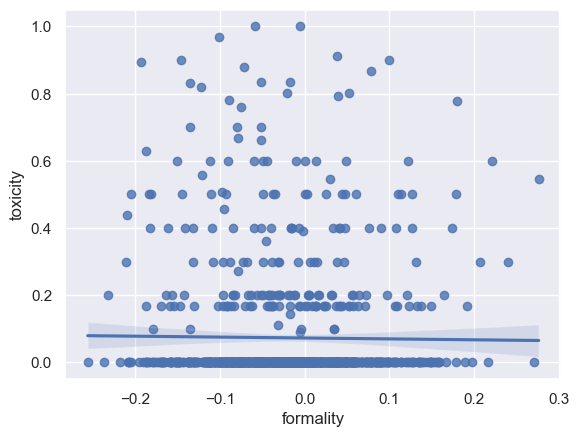

In [58]:
sns.regplot(x=complexities, y=toxicity_scores)
plt.xlabel("formality")
plt.ylabel("toxicity")

In [45]:
import numpy as np
import scipy.stats

scipy.stats.pearsonr(complexities, toxicity_scores)    # Pearson's r

PearsonRResult(statistic=-0.0122927000178309, pvalue=0.6978252746523398)

Complexity and emotionality are positively correlated, as predicted. As emotionality increases, toxicity increases. 

In [55]:
sentences = dataset["train"][:1000]['text']

toxicity_analysis = pd.DataFrame()
toxicity_analysis['sentence'] = sentences
toxicity_analysis['toxicity'] = toxicity_scores
toxicity_analysis['predicted_formality'] = complexities



In [56]:
# print most emotional
toxicity_analysis.sort_values(by="predicted_formality").head(25)

,sentence,toxicity,predicted_formality
590,RIP Carrie.,0.000000,-0.255941
329,I hear Ash's coming back to life (death?) this...,0.000000,-0.237033
546,I just laughed so hard at this that my sides h...,0.200000,-0.232402
140,Me too!,0.000000,-0.217344
566,I've never been more disappointed in my life w...,0.300000,-0.210237
11,This is a great story. Man. I wonder if the pe...,0.440000,-0.210194
635,"I love Fred, Carrie, Portlandia and living in ...",0.000000,-0.207923
149,Seriously? Wow. Who's going to trust anything ...,0.000000,-0.207839
718,"Nice! Loved your ""How to Win the Lottery"" talk...",0.000000,-0.206834
879,"""Trash...present in the rest of downtown Portl...",0.500000,-0.205296


In [57]:
# print least emotional
toxicity_analysis.sort_values(by="predicted_formality", ascending=False).head(25)

,sentence,toxicity,predicted_formality
648,This is what a serious mental illness looks li...,0.545455,0.276147
708,"In what possible universe are any of them ""pat...",0.000000,0.271116
896,It will be interesting to see the response fro...,0.300000,0.240066
609,This is what a serious mental illness looks li...,0.600000,0.221379
865,And what is a militant anyway. Is it just beca...,0.000000,0.216395
658,please tell me what law allows a group of arme...,0.300000,0.206408
725,What about the native artifacts? How will that...,0.000000,0.197813
728,"Question #3, This isn't a typical situation th...",0.166667,0.191875
95,If it is effective in slowing us down in order...,0.000000,0.189678
649,"""Real freedom""? Freedom to kill wantonly when ...",0.777778,0.180274
